In [1]:
import gym
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import scipy.linalg as la

# Model Free Stabilization and Optimization
Here we will just demonstrate a "model-free" procedure (which does not compute $(A,B,Q,R)$). It is assumed that there are $n$ states and $p$ inputs.

Say that $Q$ and $R$ are both positive definite. Then if the system is stabilizable, it computes a sequence of gains $K_i$  with the following properties:

* $K_i$ is a stabilizing controller for all sufficiently large $i$.
* The algorithm provides a certificate of stability  once a stabilizing controller is found.
* $K_i$ converges to the optimum gain geometrically. 
    
    
The method works as follows:
* Generate $N$ samples $(x_j,u_j,c_j,x_j^+)$, where
    - $x_j^+=Ax_j+Bu_j$.
    - $c_j = x_j^\top Q x_j + u_j^\top R u_j$
    - Any $u_j$ sequence with sufficient noise injection for invertibility will work. 
    - Having $N$ of order $(n+p)^2$ works.
* Start with $K_i=0$ and discount factor $\gamma_i = 0$.
* For each $i\ge 0$ do the following.
    - Solve for the action-value function, $Q_{i}(x,u)$ by least-squares, based on the system of equations $c_j = Q_{i}(x_j,u_j) - \gamma_i Q_{i}(x_j^+,K_i x_j^+)$. 
    - Compute $P_i$ such that $x^\top P_i x = Q_i(x,K_i x)$. This is the matrix corresponding to the value function.
    - Let $\gamma_{i+1} > \gamma_i$  be chosen as follows:
        - Let $\hat Q_i$ be the action-value function computed from the equations $c_j = \hat Q_{i}(x_j,u_j) - \gamma_{i+1} \hat Q_{i}(x_j^+,K_i x_j^+)$
        - Let $\hat P_i$ be the corresponding value function matrix
        - Use bisection to find the largest value of $\gamma_{i+1}$ so that
            - $\gamma_{i+1} \le 1$
            - $\hat P_i$ is positive definite
            - $\|P_i - \hat P_i \|\le 1$. (For some matrix norm, e.g. Frobenius or induced 2 norm.)
           
    - Let $K_{i+1}$ be the minimizing gain: $\min_u \hat Q_i(x,u) = \hat Q_i(x,K_{i+1})$
    
    
With this description, the properties of the algorithm can be described more precisely.
* $\gamma_i$ is monotonically increasing.
* For all $i$, $K_i$ stabilizes the system $(\sqrt{\gamma_i} A,\sqrt{\gamma_i}B)$.
* If $\gamma_i = 1$, then $K_i$ is stabilizing. Furthermore, $\gamma_j=1$ and $K_j$ is stabilizing for all $j\ge i$.
* If the system is stabilizable, then:
    - $\gamma_i=1$ after finitely many steps
    - Once $\gamma_i=1$, the steps become equivalent to policy iteration, and thus converge to the optimal gain.
* If the system is not stabilizable,then $\lim_{i\to\infty} \gamma_i =\hat\gamma$ such that $(\sqrt{\hat \gamma} A,\sqrt{\hat \gamma }B)$ is not stabilizable. 

In [101]:
#######  Helper Code #######

# Use this to generate random systems for testing
import numpy.random as rnd
import scipy.stats as st

def randomSystem(n=None,p=None):

    if n is None:
        n = rnd.randint(1,10)
    if p is None:
        p = rnd.randint(1,10)

    A = rnd.randn(n,n)
    B = rnd.randn(n,p)

    Q = st.wishart.rvs(n+1,np.eye(n)).reshape((n,n))
    R = st.wishart.rvs(p+1,np.eye(p)).reshape((p,p))
    
    return A,B,Q,R

def trilStack(M):
    n = len(M)
    v = []
    for i in range(n):
        v.append(M[i:,i])
    return np.hstack(v)

def trilUnstack(v):
    d = len(v)
    n = int((np.sqrt(1+8*d)-1)/2)
    M = np.zeros((n,n))
    j = 0
    for i in range(n):
        M[i:,i] = v[j:j+n-i]
        j = j+n-i
    return M

def symFromTrilStack(v):
    L = trilUnstack(v)
    D = np.diag(np.diag(L))
    return L + L.T - D

def quadraticMonomials(z):
    M = np.outer(z,z)
    M_L = np.tril(M,-1)
    M_D = np.diag(np.diag(M))
    return trilStack(2*M_L + M_D)

def buildPhi(X,U,X_next,K,gamma):
    Horizon = len(U)
    Phi = []
    for x,u,x_next in zip(X,U,X_next):
        z = np.hstack([x,u])
        z_next = np.hstack([x_next,K@x_next])
        # Accounting for noise requires extra parameter
        psi = np.hstack(quadraticMonomials(z))
        psi_next = np.hstack(quadraticMonomials(z_next))
        phi = psi - gamma * psi_next
        Phi.append(phi)
    return np.array(Phi)
    
    
    
def getVandQmatrices(X,U,X_next,c,K,gamma):
    F = np.vstack([np.eye(n),K])
    Phi = buildPhi(X,U,X_next,K,gamma)
    theta = la.lstsq(Phi,c)[0]
    # The first entry of theta is the noise variance
    Q_mat = symFromTrilStack(theta)
    P = F.T @ Q_mat @ F
    return P,Q_mat
    
def increaseGamma(X,U,X_next,c,K,gamma,changeBound=1):
    
    LB = gamma 
    UB = 1.
    
    p,n = K.shape
    
    # Get the current P value
    P_cur,Q_mat = getVandQmatrices(X,U,X_next,c,K,gamma)
        
    # Try 1 first
    gamma = 1.
    P_new,Q_mat = getVandQmatrices(X,U,X_next,c,K,gamma)
    

    
    P_change = la.norm(P_new-P_cur)
    minEig = la.eigvalsh(P_new,eigvals=[0,0])[0]
    
    if minEig > 0:
        # gamma = 1 worked
        return gamma, Q_mat
    
    
    while ((UB-LB) > 1e-6) or (minEig < 0) or (P_change > changeBound):
        
        P_new,Q_mat = getVandQmatrices(X,U,X_next,c,K,gamma)
        minEig = la.eigvalsh(P_new,eigvals=[0,0])[0]
        
        P_change = la.norm(P_cur-P_new)
  
        if (minEig < 0) or (P_change > changeBound):
            UB = gamma
            
        else:
            LB = gamma
            
        gamma = .5 * (LB+UB)
        
            
        
    return gamma, Q_mat

def extractGain(Q_mat,n):
    Omega = Q_mat[n:,n:]
    Psi = Q_mat[n:,:n]
    K = -la.solve(Omega,Psi)
    return K
    
def genX(n,b):
    r = rnd.rand() * b
    x = rnd.randn(n)
    return r * x / la.norm(x)

#### Main Code ##### 

A,B,Q,R = randomSystem(10,2)
n,p = B.shape


NumEpisodes = 10
x_bound = 100
x = genX(n,x_bound)

Horizon = (p+n)*(p+n+1)
K = np.zeros((p,n))
gamma = 0.


P_opt = la.solve_discrete_are(A,B,Q,R)
K_opt = -la.solve(R+B.T@P_opt@B,B.T@P_opt@A)

K_err = 10

ep =0

X = []
U = []
X_next = []
c = []# Simulate the system
for t in range(Horizon):
    u = K@x + .1 * rnd.randn(p)
    x_next = A@x + B @ u 
    c.append(x@Q@x + u@R@u)
    X.append(x)
    U.append(u)
    X_next.append(x_next)
    if la.norm(x_next) <= x_bound:
        x = x_next
    else:
        x = genX(n,x_bound)
        
c = np.array(c)

ErrList = []
GammaList = []
RhoList = []

while K_err > 1e-6 :
    ep += 1
 
    
    eigMax = np.max(np.abs(la.eigvals(A+B@K)))
    K_err = la.norm(K-K_opt)
    ErrList.append(K_err)
    GammaList.append(gamma)
    RhoList.append(eigMax)
    print('Episode: ',ep,', ||K-K*||:',K_err, ', rho(A+BK):', eigMax,', gamma:', gamma)
    gamma,Q_mat = increaseGamma(X,U,X_next,c,K,gamma,changeBound=1e4)
    # improve K
    K = extractGain(Q_mat,n)


Episode:  1 , ||K-K*||: 6.722109219061238 , rho(A+BK): 2.995079942799653 , gamma: 0.0
Episode:  2 , ||K-K*||: 7.848599365985266 , rho(A+BK): 2.2325587677764434 , gamma: 0.11019659042358398
Episode:  3 , ||K-K*||: 4.66350675231953 , rho(A+BK): 2.103885439720678 , gamma: 0.19734390798089407
Episode:  4 , ||K-K*||: 3.665769276303428 , rho(A+BK): 1.7535637490458056 , gamma: 0.22402177280996116
Episode:  5 , ||K-K*||: 2.6700408929424744 , rho(A+BK): 1.1649906838674546 , gamma: 0.32064570581876106
Episode:  6 , ||K-K*||: 0.9081949313736737 , rho(A+BK): 1.0324727036364207 , gamma: 0.4246987516431976
Episode:  7 , ||K-K*||: 0.6599444349893377 , rho(A+BK): 0.9913549801311032 , gamma: 0.5005443368089963
Episode:  8 , ||K-K*||: 1.2396584756439015 , rho(A+BK): 0.7149710832974842 , gamma: 1.0
Episode:  9 , ||K-K*||: 0.6751182934998058 , rho(A+BK): 0.5848274077332539 , gamma: 1.0
Episode:  10 , ||K-K*||: 0.00970950710963169 , rho(A+BK): 0.5250403902468446 , gamma: 1.0
Episode:  11 , ||K-K*||: 0.0001

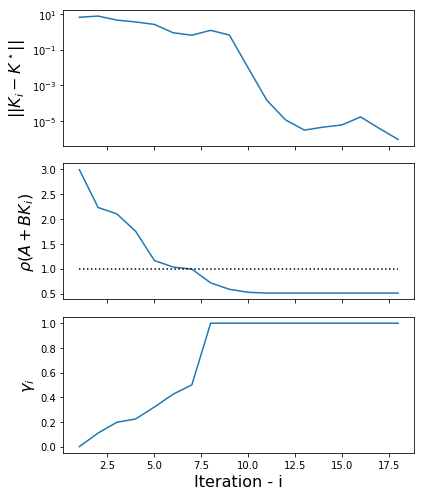

In [102]:
Time = np.arange(1,len(RhoList)+1)
fig,ax = plt.subplots(3,1,figsize=(6,7),sharex=True)
ax[0].semilogy(Time,ErrList)
ax[0].set_ylabel(r'$||K_i - K^\star||$',fontsize=16)
ax[1].plot(Time,RhoList)
ax[1].plot(Time,np.ones_like(Time),'k:')
ax[1].set_ylabel(r'$\rho(A+BK_i)$',fontsize=16)
ax[2].plot(Time,GammaList)
ax[2].set_ylabel(r'$\gamma_i$',fontsize=16)
ax[2].set_xlabel('Iteration - i',fontsize=16)
fig.tight_layout()
plt.savefig('AlgPerformance.pdf',bbox_inches='tight',transparent=True)

In [58]:
# Here is a test on a toy system controllable system

A = np.array([[2.,1.],
              [0,3.]])
B = np.array([[0.],
              [1.]])
Q = np.eye(2)
R = np.eye(1)
#A,B,Q,R = randomSystem(5,1)
n,p = B.shape

NumEpisodes = 10
x_bound = 100
x = genX(n,x_bound)

Horizon = (p+n)*(p+n+1)
K = np.zeros((p,n))
gamma = 0.


P_opt = la.solve_discrete_are(A,B,Q,R)
K_opt = -la.solve(R+B.T@P_opt@B,B.T@P_opt@A)

K_err = 10

ep =0

X = []
U = []
X_next = []
c = []# Simulate the system
for t in range(Horizon):
    u = K@x + .1 * rnd.randn(p)
    x_next = A@x + B @ u 
    c.append(x@Q@x + u@R@u)
    X.append(x)
    U.append(u)
    X_next.append(x_next)
    if la.norm(x_next) <= x_bound:
        x = x_next
    else:
        x = genX(n,x_bound)
        
c = np.array(c)

while K_err > 1e-6 :
    ep += 1
 
    
    eigMax = np.max(np.abs(la.eigvals(A+B@K)))
    K_err = la.norm(K-K_opt)
    print('Episode: ',ep,', ||K-K*||:',K_err, ', rho(A+BK):', eigMax,', gamma:', gamma)
    gamma,Q_mat = increaseGamma(X,U,X_next,c,K,gamma)
    # improve K
    K = extractGain(Q_mat,n)


Episode:  1 , ||K-K*||: 4.9750267558612045 , rho(A+BK): 3.0 , gamma: 0.0
Episode:  2 , ||K-K*||: 3.4214425323283124 , rho(A+BK): 1.9306142785192975 , gamma: 0.10107421875
Episode:  3 , ||K-K*||: 2.1285876003842445 , rho(A+BK): 1.081373531564986 , gamma: 0.24109244346618652
Episode:  4 , ||K-K*||: 1.5269844259910255 , rho(A+BK): 1.0161264373887307 , gamma: 0.4304487722693011
Episode:  5 , ||K-K*||: 0.18772513793100484 , rho(A+BK): 0.6197988666466727 , gamma: 0.7149462849492352
Episode:  6 , ||K-K*||: 0.021140058276136273 , rho(A+BK): 0.4325494902277658 , gamma: 1.0
Episode:  7 , ||K-K*||: 0.00015851066742069534 , rho(A+BK): 0.4513086342540946 , gamma: 1.0
Episode:  8 , ||K-K*||: 1.3650682838545302e-08 , rho(A+BK): 0.451416222968021 , gamma: 1.0


In [57]:
# Here is a test on a toy system uncontrollable system

A = np.array([[2.,0.],
              [0,3.]])
B = np.array([[0.],
              [1.]])
Q = np.eye(2)
R = np.eye(1)
#A,B,Q,R = randomSystem(5,1)
n,p = B.shape

NumEpisodes = 10
x_bound = 100
x = genX(n,x_bound)

Horizon = (p+n)*(p+n+1)
K = np.zeros((p,n))
gamma = 0.


#P_opt = la.solve_discrete_are(A,B,Q,R)
#K_opt = -la.solve(R+B.T@P_opt@B,B.T@P_opt@A)

#K_err = 10

ep =0

X = []
U = []
X_next = []
c = []# Simulate the system
for t in range(Horizon):
    u = K@x + .1 * rnd.randn(p)
    x_next = A@x + B @ u 
    c.append(x@Q@x + u@R@u)
    X.append(x)
    U.append(u)
    X_next.append(x_next)
    if la.norm(x_next) <= x_bound:
        x = x_next
    else:
        x = genX(n,x_bound)
        
c = np.array(c)

for ep in range(10):
    ep += 1
 
    
    eigMax = np.max(np.abs(la.eigvals(A+B@K)))
    K_err = la.norm(K-K_opt)
    print('Episode: ',ep,' rho(A+BK):', eigMax,' rho(sqrt{gamma} (A+BK)):', np.sqrt(gamma) * eigMax,', gamma:', gamma)
    gamma,Q_mat = increaseGamma(X,U,X_next,c,K,gamma)
    # improve K
    K = extractGain(Q_mat,n)

    print()

Episode:  1  rho(A+BK): 3.0  rho(sqrt{gamma} (A+BK)): 0.0 , gamma: 0.0

Episode:  2  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.6636487681748532 , gamma: 0.110107421875

Episode:  3  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.9691523054988117 , gamma: 0.23481404781341553

Episode:  4  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.992766744735368 , gamma: 0.2463964523631148

Episode:  5  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.9949881683916619 , gamma: 0.24750036380984852

Episode:  6  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.9960953990543752 , gamma: 0.2480515110043237

Episode:  7  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.9972005907068795 , gamma: 0.24860225452653734

Episode:  8  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.9977523231731261 , gamma: 0.24887742459934256

Episode:  9  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.9983035488304295 , gamma: 0.24915249390185745

Episode:  10  rho(A+BK): 2.0  rho(sqrt{gamma} (A+BK)): 0.9985789466765687 , gamma: 0.24928997818642132

